In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install required libraries
!pip install torch torchvision transformers pillow pandas numpy matplotlib scikit-learn tqdm

# Import necessary libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import DistilBertTokenizer, DistilBertModel


# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Define paths
BASE_PATH = '/content/drive/MyDrive/coursework'
METADATA_PATH = '/content/drive/MyDrive/coursework/nutrition5k_metadata/nutrition5k_dataset/metadata'
IMAGES_PATH = '/content/drive/MyDrive/coursework/nutrition5k_dataset/imagery/realsense_overhead'
CHECKPOINT_PATH = os.path.join(BASE_PATH, 'model_checkpoints')

# Create checkpoint directory
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

print("Paths configured:")
print(f"Metadata: {METADATA_PATH}")
print(f"Images: {IMAGES_PATH}")
print(f"Checkpoints: {CHECKPOINT_PATH}")

Paths configured:
Metadata: /content/drive/MyDrive/coursework/nutrition5k_metadata/nutrition5k_dataset/metadata
Images: /content/drive/MyDrive/coursework/nutrition5k_dataset/imagery/realsense_overhead
Checkpoints: /content/drive/MyDrive/coursework/model_checkpoints


In [5]:
# Load all metadata files
cafe1_df = pd.read_csv(os.path.join(METADATA_PATH, 'dish_metadata_cafe1.csv'),
                       on_bad_lines='skip', engine='python')
cafe2_df = pd.read_csv(os.path.join(METADATA_PATH, 'dish_metadata_cafe2.csv'),
                       on_bad_lines='skip', engine='python')
ingredients_df = pd.read_csv(os.path.join(METADATA_PATH, 'ingredients_metadata.csv'),
                             on_bad_lines='skip', engine='python')

# Combine cafe metadata
metadata_df = pd.concat([cafe1_df, cafe2_df], ignore_index=True)

print(f"Cafe1 shape: {cafe1_df.shape}")
print(f"Cafe2 shape: {cafe2_df.shape}")
print(f"Combined metadata shape: {metadata_df.shape}")
print(f"Ingredients shape: {ingredients_df.shape}")

Cafe1 shape: (4391, 125)
Cafe2 shape: (190, 62)
Combined metadata shape: (4581, 177)
Ingredients shape: (555, 6)


In [6]:
# The metadata files don't have proper headers, reload them
cafe1_df = pd.read_csv(os.path.join(METADATA_PATH, 'dish_metadata_cafe1.csv'),
                       header=None, on_bad_lines='skip', engine='python')
cafe2_df = pd.read_csv(os.path.join(METADATA_PATH, 'dish_metadata_cafe2.csv'),
                       header=None, on_bad_lines='skip', engine='python')

# Combine cafe metadata
metadata_df = pd.concat([cafe1_df, cafe2_df], ignore_index=True)

print(f"Metadata shape: {metadata_df.shape}")
print(f"\nFirst 5 rows:")
print(metadata_df.head())

# The first column should be dish_id, second should be total_calories
print(f"\n=== First few dish IDs and calories ===")
print(metadata_df[[0, 1]].head(10))

# Check data types
print(f"\nColumn 0 (dish_id) sample: {metadata_df.iloc[0, 0]}")
print(f"Column 1 (calories) sample: {metadata_df.iloc[0, 1]}")

print(f"\n=== Ingredients (already loaded correctly) ===")
print(f"Shape: {ingredients_df.shape}")
print(ingredients_df.head())

Metadata shape: (4583, 125)

First 5 rows:
               0           1      2          3          4          5    \
0  dish_1561662216  300.794281  193.0  12.387489  28.218290  18.633970   
1  dish_1562688426  137.569992   88.0   8.256000   5.190000  10.297000   
2  dish_1561662054  419.438782  292.0  23.838249  26.351543  25.910593   
3  dish_1562008979  382.936646  290.0  22.224644  10.173570  35.345387   
4  dish_1560455030   20.590000  103.0   0.148000   4.625000   0.956000   

               6                 7          8          9    ...       115  \
0  ingr_0000000508         soy sauce   3.398568   1.801241  ...  0.000425   
1  ingr_0000000433  roasted potatoes  17.000000  23.970000  ...       NaN   
2  ingr_0000000312            pepper   0.300716   0.120286  ...  0.000000   
3  ingr_0000000448         jalapenos   0.192961   0.055959  ...       NaN   
4  ingr_0000000471   cherry tomatoes  55.000000   9.900000  ...       NaN   

        116       117              118      119  

=== METADATA STATISTICS ===
Total dishes: 4583

Calories statistics:
count    4583.000000
mean      195.688704
std       309.117025
min         0.000000
25%        45.995001
50%       126.574638
75%       281.006134
max      9485.815430
Name: total_calories, dtype: float64

Mass statistics (grams):
count    4583.000000
mean      176.482653
std       274.342755
min         1.000000
25%        68.000000
50%       133.000000
75%       228.000000
max      7975.000000
Name: total_mass, dtype: float64


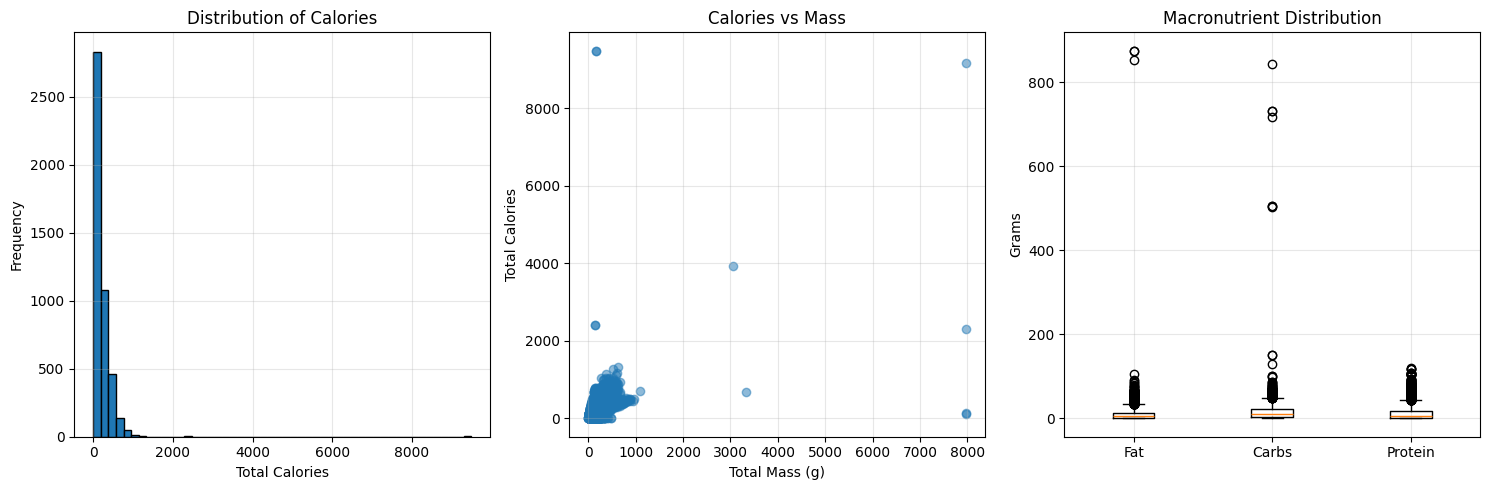


=== INGREDIENTS ===
Total unique ingredients: 555

Top 10 ingredients by calorie density:
               ingr  cal/g  fat(g)  carb(g)  protein(g)
255        fish oil  9.033   1.010    0.000       0.000
220   vegetable oil  8.864   1.000    0.000       0.000
554             oil  8.864   1.000    0.000       0.000
160       olive oil  8.840   1.000    0.000       0.000
222  macadamia nuts  7.188   0.750    0.139       0.079
87        margarine  7.170   0.810    0.007       0.002
440          butter  7.170   0.810    0.001       0.008
81           pecans  6.900   0.720    0.140       0.090
115      mayonnaise  6.800   0.750    0.006       0.010
221       pine nuts  6.646   0.685    0.126       0.132


In [7]:
# Rename columns for easier access
metadata_df.columns = ['dish_id', 'total_calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein'] + [f'col_{i}' for i in range(6, metadata_df.shape[1])]

print("=== METADATA STATISTICS ===")
print(f"Total dishes: {len(metadata_df)}")
print(f"\nCalories statistics:")
print(metadata_df['total_calories'].describe())

print(f"\nMass statistics (grams):")
print(metadata_df['total_mass'].describe())

# Visualize calorie distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(metadata_df['total_calories'], bins=50, edgecolor='black')
plt.xlabel('Total Calories')
plt.ylabel('Frequency')
plt.title('Distribution of Calories')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.scatter(metadata_df['total_mass'], metadata_df['total_calories'], alpha=0.5)
plt.xlabel('Total Mass (g)')
plt.ylabel('Total Calories')
plt.title('Calories vs Mass')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.boxplot([metadata_df['total_fat'], metadata_df['total_carb'], metadata_df['total_protein']])
plt.xticks([1, 2, 3], ['Fat', 'Carbs', 'Protein'])
plt.ylabel('Grams')
plt.title('Macronutrient Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== INGREDIENTS ===")
print(f"Total unique ingredients: {len(ingredients_df)}")
print(f"\nTop 10 ingredients by calorie density:")
print(ingredients_df.nlargest(10, 'cal/g')[['ingr', 'cal/g', 'fat(g)', 'carb(g)', 'protein(g)']])

Total dish folders: 3491

Sample dish folder: dish_1558031566
Files in sample folder:
  - rgb.png
  - depth_color.png
  - depth_raw.png


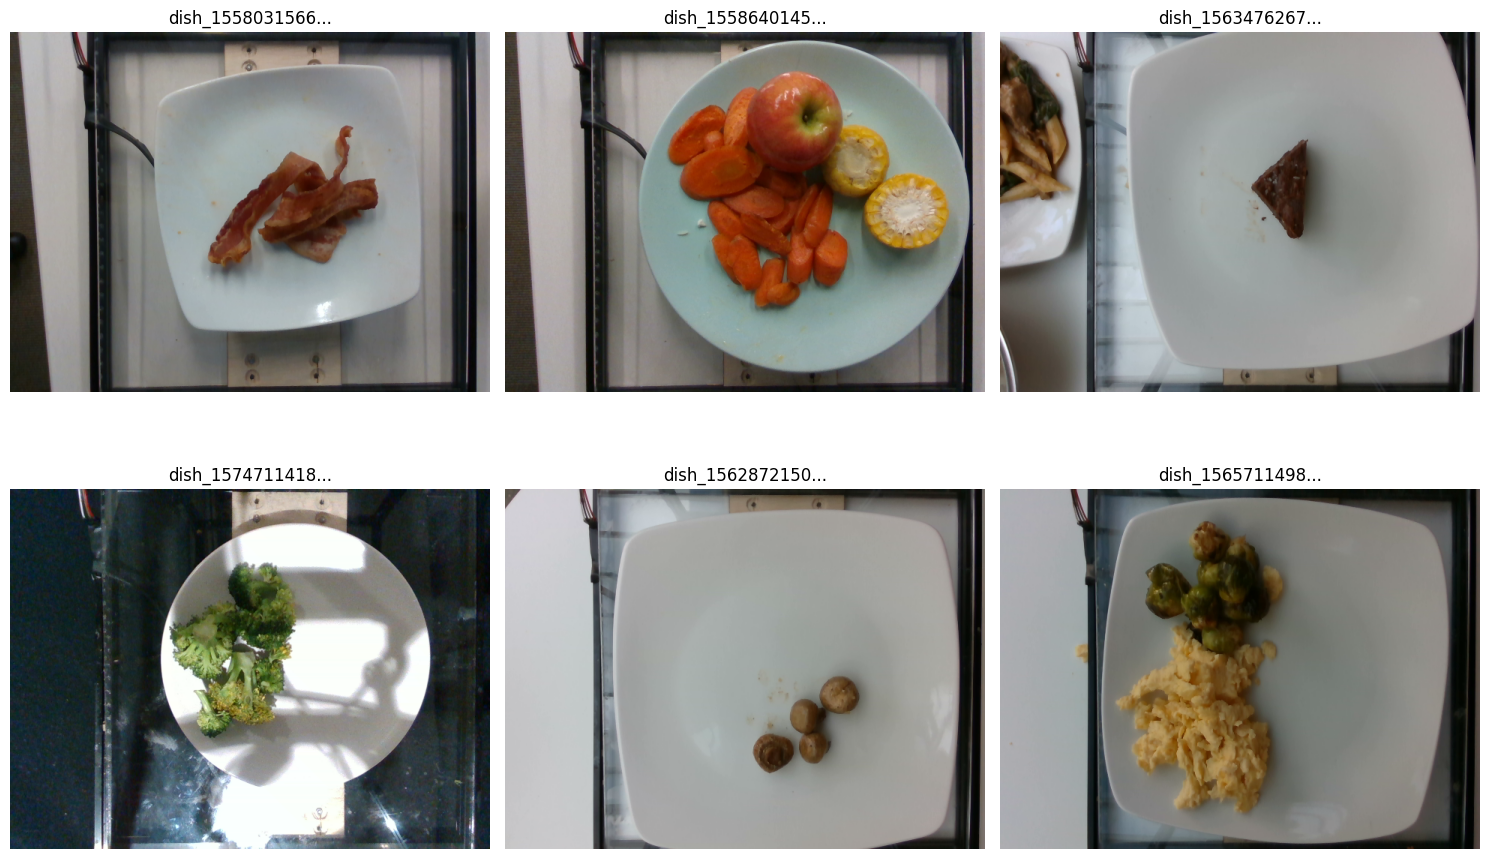


Sample image dimensions: (640, 480)
Image mode: RGB


In [8]:
# Get all dish folders
dish_folders = [f for f in os.listdir(IMAGES_PATH) if f.startswith('dish_')]
print(f"Total dish folders: {len(dish_folders)}")

# Check a sample dish folder
sample_dish = dish_folders[0]
sample_path = os.path.join(IMAGES_PATH, sample_dish)
print(f"\nSample dish folder: {sample_dish}")
print(f"Files in sample folder:")
files_in_sample = os.listdir(sample_path)
for f in files_in_sample:
    print(f"  - {f}")

# Load and display sample images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    if i < len(dish_folders):
        dish_folder = dish_folders[i]
        dish_path = os.path.join(IMAGES_PATH, dish_folder)

        # Find RGB image
        rgb_files = [f for f in os.listdir(dish_path) if 'rgb' in f.lower() and f.endswith('.png')]

        if rgb_files:
            img_path = os.path.join(dish_path, rgb_files[0])
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{dish_folder[:15]}...")
            axes[i].axis('off')

plt.tight_layout()
plt.show()

# Check image dimensions
sample_img_path = os.path.join(IMAGES_PATH, dish_folders[0], 'rgb.png')
if os.path.exists(sample_img_path):
    sample_img = Image.open(sample_img_path)
    print(f"\nSample image dimensions: {sample_img.size}")
    print(f"Image mode: {sample_img.mode}")

In [10]:
# Match images with metadata and ingredients
data_list = []

for dish_folder in tqdm(dish_folders, desc="Creating dataset"):
    # Extract dish_id from folder name (e.g., dish_1561662216 -> dish_1561662216)
    dish_id = dish_folder

    # Get image path
    dish_path = os.path.join(IMAGES_PATH, dish_folder)
    rgb_files = [f for f in os.listdir(dish_path) if 'rgb' in f.lower() and f.endswith('.png')]

    if rgb_files:
        image_path = os.path.join(dish_path, rgb_files[0])

        # Find matching metadata row
        matching_meta = metadata_df[metadata_df['dish_id'] == dish_id]

        if len(matching_meta) > 0:
            calories = matching_meta.iloc[0]['total_calories']
            mass = matching_meta.iloc[0]['total_mass']
            fat = matching_meta.iloc[0]['total_fat']
            carb = matching_meta.iloc[0]['total_carb']
            protein = matching_meta.iloc[0]['total_protein']

            # Extract ingredient information from the row (ingredients are in columns starting from col_6)
            # Ingredients alternate: id, name, amount, ...
            ingredients_list = []
            row = matching_meta.iloc[0]

            # Parse ingredients from the metadata row
            for j in range(6, len(row), 6):  # Ingredients appear in sets
                if j < len(row) and pd.notna(row.iloc[j]):
                    ingr_name = row.iloc[j+1] if j+1 < len(row) and pd.notna(row.iloc[j+1]) else ""
                    if ingr_name and ingr_name != "":
                        ingredients_list.append(str(ingr_name))

            # Create ingredient text
            ingredient_text = ", ".join(ingredients_list) if ingredients_list else "unknown ingredients"

            if pd.notna(calories) and float(calories) > 0:
                data_list.append({
                    'dish_id': dish_id,
                    'image_path': image_path,
                    'text': ingredient_text,
                    'calories': float(calories),
                    'mass': float(mass) if pd.notna(mass) else 0,
                    'fat': float(fat) if pd.notna(fat) else 0,
                    'carb': float(carb) if pd.notna(carb) else 0,
                    'protein': float(protein) if pd.notna(protein) else 0
                })

# Create DataFrame
df = pd.DataFrame(data_list)

print(f"=== DATASET CREATED ===")
print(f"Total samples: {len(df)}")
print(f"\nCalories statistics:")
print(df['calories'].describe())
print(f"\nSample data:")
print(df[['dish_id', 'text', 'calories']].head(10))

# Save dataset
df.to_csv(os.path.join(BASE_PATH, 'prepared_dataset.csv'), index=False)
print(f"\nDataset saved!")

Creating dataset: 100%|██████████| 3491/3491 [00:16<00:00, 208.56it/s]


=== DATASET CREATED ===
Total samples: 2892

Calories statistics:
count    2892.000000
mean      229.745324
std       209.499955
min         1.150000
25%        72.784378
50%       177.629997
75%       338.651902
max      3943.325195
Name: calories, dtype: float64

Sample data:
           dish_id                                               text  \
0  dish_1558031566                                              bacon   
1  dish_1558640145              carrot, ingr_0000000054, 0.348, 16.06   
2  dish_1563476267                                           brownies   
3  dish_1562872150                                           mushroom   
4  dish_1565711498  salt, ingr_0000000312, 0.00233702, 8.41328406,...   
5  dish_1560453275  lemon juice, ingr_0000000036, 0.034268836, 0.0...   
6  dish_1566838407  pineapple, ingr_0000000008, 6.5, 13.34634246, ...   
7  dish_1559233144          garden salad, ingr_0000000008, 12.4, 0.49   
8  dish_1561662501  olive oil, ingr_0000000312, 0.00163266, 20.0

=== DATASET SPLIT ===
Total samples: 2892
Train samples: 2024 (70.0%)
Validation samples: 434 (15.0%)
Test samples: 434 (15.0%)

=== Calorie Distribution ===
Train - Mean: 234.33, Std: 216.86
Val   - Mean: 219.81, Std: 201.32
Test  - Mean: 218.29, Std: 180.19


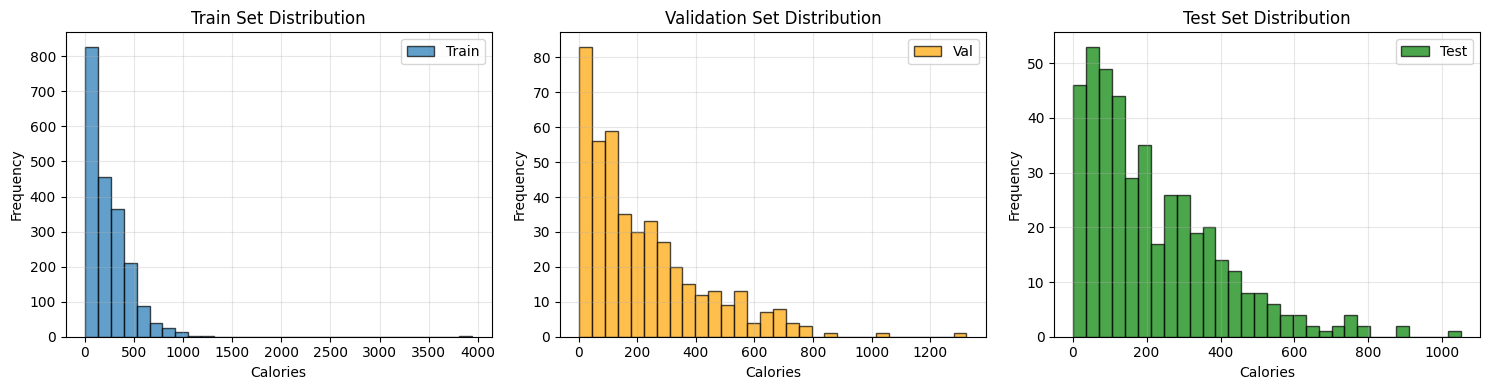


Splits saved to drive!


In [11]:
from sklearn.model_selection import train_test_split

# Split dataset: 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"=== DATASET SPLIT ===")
print(f"Total samples: {len(df)}")
print(f"Train samples: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation samples: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test samples: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# Check calorie distribution in each split
print(f"\n=== Calorie Distribution ===")
print(f"Train - Mean: {train_df['calories'].mean():.2f}, Std: {train_df['calories'].std():.2f}")
print(f"Val   - Mean: {val_df['calories'].mean():.2f}, Std: {val_df['calories'].std():.2f}")
print(f"Test  - Mean: {test_df['calories'].mean():.2f}, Std: {test_df['calories'].std():.2f}")

# Visualize splits
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(train_df['calories'], bins=30, alpha=0.7, label='Train', edgecolor='black')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.title('Train Set Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(val_df['calories'], bins=30, alpha=0.7, label='Val', color='orange', edgecolor='black')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.title('Validation Set Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(test_df['calories'], bins=30, alpha=0.7, label='Test', color='green', edgecolor='black')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.title('Test Set Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save splits
train_df.to_csv(os.path.join(BASE_PATH, 'train_data.csv'), index=False)
val_df.to_csv(os.path.join(BASE_PATH, 'val_data.csv'), index=False)
test_df.to_csv(os.path.join(BASE_PATH, 'test_data.csv'), index=False)

print(f"\nSplits saved to drive!")

In [12]:
# Custom Dataset class for images + text
class FoodCalorieDataset(Dataset):
    def __init__(self, dataframe, transform=None, max_text_length=100):
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        self.max_text_length = max_text_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image
        img_path = self.data.loc[idx, 'image_path']
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Get text (ingredients)
        text = str(self.data.loc[idx, 'text'])

        # Simple text encoding: convert to lowercase and limit length
        text = text.lower()[:self.max_text_length]

        # Get target (calories)
        calories = torch.tensor(self.data.loc[idx, 'calories'], dtype=torch.float32)

        return {
            'image': image,
            'text': text,
            'calories': calories,
            'dish_id': self.data.loc[idx, 'dish_id']
        }

# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = FoodCalorieDataset(train_df, transform=train_transform)
val_dataset = FoodCalorieDataset(val_df, transform=val_transform)
test_dataset = FoodCalorieDataset(test_df, transform=val_transform)

print(f"=== DATASETS CREATED ===")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Test loading one sample
sample = train_dataset[0]
print(f"\n=== SAMPLE DATA ===")
print(f"Image shape: {sample['image'].shape}")
print(f"Text: {sample['text'][:100]}...")
print(f"Calories: {sample['calories'].item():.2f}")
print(f"Dish ID: {sample['dish_id']}")

=== DATASETS CREATED ===
Train dataset size: 2024
Val dataset size: 434
Test dataset size: 434

=== SAMPLE DATA ===
Image shape: torch.Size([3, 224, 224])
Text: cheese pizza...
Calories: 404.17
Dish ID: dish_1564605293


In [13]:
# Create data loaders
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"=== DATA LOADERS CREATED ===")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Test loading one batch
print(f"\n=== SAMPLE BATCH ===")
for batch in train_loader:
    print(f"Batch image shape: {batch['image'].shape}")
    print(f"Batch calories shape: {batch['calories'].shape}")
    print(f"Number of texts: {len(batch['text'])}")
    print(f"Sample text: {batch['text'][0][:80]}...")
    print(f"Sample calories: {batch['calories'][0].item():.2f}")
    break

=== DATA LOADERS CREATED ===
Train batches: 127
Val batches: 28
Test batches: 28

=== SAMPLE BATCH ===


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch image shape: torch.Size([16, 3, 224, 224])
Batch calories shape: torch.Size([16])
Number of texts: 16
Sample text: sweet potato, ingr_0000000161...
Sample calories: 116.76


In [14]:
# Initialize BERT tokenizer (pre-trained)
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

print(f"✅ BERT tokenizer loaded!")
print(f"Vocabulary size: {bert_tokenizer.vocab_size}")

# Multimodal Model with BERT: Image + Text -> Calories
class CaloriePredictionModelBERT(nn.Module):
    def __init__(self):
        super(CaloriePredictionModelBERT, self).__init__()

        # Image encoder: pretrained ResNet
        resnet = models.resnet50(pretrained=True)
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.image_fc = nn.Linear(2048, 512)

        # Text encoder: DistilBERT
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze most BERT layers (train only last 2 transformer layers)
        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.bert.transformer.layer[-2:].parameters():
            param.requires_grad = True

        # BERT output projection
        self.text_fc = nn.Linear(768, 256)

        # Fusion and regression head
        self.fusion = nn.Sequential(
            nn.Linear(512 + 256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, images, input_ids, attention_mask):
        # Image features
        img_features = self.image_encoder(images)
        img_features = img_features.view(img_features.size(0), -1)
        img_features = self.image_fc(img_features)
        img_features = torch.relu(img_features)

        # Text features with BERT
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = bert_output.last_hidden_state[:, 0, :]
        text_features = self.text_fc(text_features)
        text_features = torch.relu(text_features)

        # Fuse features
        combined = torch.cat([img_features, text_features], dim=1)
        output = self.fusion(combined)

        return output.squeeze()

# Initialize model
model = CaloriePredictionModelBERT()
model = model.to(device)

print(f"=== MODEL WITH BERT CREATED ===")
print(f"Device: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

✅ BERT tokenizer loaded!
Vocabulary size: 30522


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

=== MODEL WITH BERT CREATED ===
Device: cpu
Total parameters: 91,642,177
Trainable parameters: 39,455,041


In [15]:
# New text processing function for BERT
def process_text_batch_bert(text_list, max_length=128):
    """Process text using BERT tokenizer"""
    encoding = bert_tokenizer(
        text_list,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    return {
        'input_ids': encoding['input_ids'].to(device),
        'attention_mask': encoding['attention_mask'].to(device)
    }

In [16]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

# Training configuration
NUM_EPOCHS = 50
BEST_VAL_LOSS = float('inf')
PATIENCE = 10  # Early stopping patience
PATIENCE_COUNTER = 0

# Checkpoint saving function
def save_checkpoint(epoch, model, optimizer, scheduler, train_loss, val_loss,
                   best_val_loss, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'best_val_loss': best_val_loss,
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved: {filepath}")

# Checkpoint loading function
def load_checkpoint(filepath, model, optimizer, scheduler):
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        print(f"Checkpoint loaded from epoch {epoch}")
        return epoch, best_val_loss
    else:
        print("No checkpoint found, starting from scratch")
        return 0, float('inf')

print("=== TRAINING SETUP COMPLETE ===")
print(f"Loss function: MSE")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Scheduler: ReduceLROnPlateau")
print(f"Max epochs: {NUM_EPOCHS}")
print(f"Early stopping patience: {PATIENCE}")

=== TRAINING SETUP COMPLETE ===
Loss function: MSE
Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau
Max epochs: 50
Early stopping patience: 10


In [17]:
# Training function
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for batch in tqdm(train_loader, desc="Training"):
        images = batch['image'].to(device)
        text_encoding = process_text_batch_bert(batch['text'])  # CHANGED
        calories = batch['calories'].to(device)

        optimizer.zero_grad()

        # CHANGED: Pass input_ids and attention_mask
        outputs = model(images, text_encoding['input_ids'], text_encoding['attention_mask'])
        loss = criterion(outputs, calories)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    return avg_loss

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            images = batch['image'].to(device)
            text_encoding = process_text_batch_bert(batch['text'])  # CHANGED
            calories = batch['calories'].to(device)

            # CHANGED: Pass input_ids and attention_mask
            outputs = model(images, text_encoding['input_ids'], text_encoding['attention_mask'])
            loss = criterion(outputs, calories)

            running_loss += loss.item()

            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(calories.cpu().numpy())

    avg_loss = running_loss / len(val_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    mae = np.mean(np.abs(all_predictions - all_targets))

    return avg_loss, mae, all_predictions, all_targets

print("=== TRAINING & VALIDATION FUNCTIONS DEFINED ===")
print("Ready to start training!")

=== TRAINING & VALIDATION FUNCTIONS DEFINED ===
Ready to start training!


In [18]:
# Smart checkpoint handler - automatically loads if exists
print("=" * 70)
print("CHECKING FOR EXISTING CHECKPOINTS")
print("=" * 70)

# Check if best BERT model exists
BERT_CHECKPOINT_FILE = os.path.join(CHECKPOINT_PATH, 'bert_latest_checkpoint.pth')
BERT_BEST_MODEL_FILE = os.path.join(CHECKPOINT_PATH, 'bert_best_model.pth')
if os.path.exists(BERT_BEST_MODEL_FILE):
    print(f"\n✅ Found existing BERT model!")

    # Load it
    checkpoint = torch.load(BERT_BEST_MODEL_FILE, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    best_mae = checkpoint.get('val_loss', 'unknown')  # Get saved MAE
    print(f"   Loaded model from epoch {checkpoint['epoch']}")
    print(f"   Best validation loss: {best_mae}")

    # Ask user what to do
    print(f"\n🤔 What would you like to do?")
    print(f"   1. Continue fine-tuning (recommended)")
    print(f"   2. Retrain from scratch (will overwrite)")

    choice = input("\nEnter choice (1 or 2): ")

    if choice == '1':
        print("\n✅ Will use existing model for fine-tuning")
        SKIP_INITIAL_TRAINING = True
    else:
        print("\n⚠️ Will retrain from scratch (this will take time!)")
        SKIP_INITIAL_TRAINING = False
else:
    print(f"\n❌ No existing BERT model found")
    print(f"   Will train from scratch")
    SKIP_INITIAL_TRAINING = False

print("=" * 70)

CHECKING FOR EXISTING CHECKPOINTS

✅ Found existing BERT model!
   Loaded model from epoch 26
   Best validation loss: 9506.671482631138

🤔 What would you like to do?
   1. Continue fine-tuning (recommended)
   2. Retrain from scratch (will overwrite)

Enter choice (1 or 2): 1

✅ Will use existing model for fine-tuning


In [19]:
# Check if there's a checkpoint to resume from
# BERT checkpoints (new names to keep old LSTM checkpoints safe)
if SKIP_INITIAL_TRAINING:
    print("⏭️ Skipping initial training - using loaded model")
else:

# Start fresh with BERT
    start_epoch = 0
    BEST_VAL_LOSS = float('inf')
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_mae': []
    }



    for epoch in range(start_epoch, NUM_EPOCHS):
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

        # Train
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_mae, val_preds, val_targets = validate(model, val_loader, criterion, device)

        # Update learning rate scheduler
        scheduler.step(val_loss)

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)

        # Print epoch results
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.2f} cal")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Save latest checkpoint
        save_checkpoint(
            epoch=epoch+1,
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            train_loss=train_loss,
            val_loss=val_loss,
            best_val_loss=BEST_VAL_LOSS,
            filepath=BERT_CHECKPOINT_FILE  # NEW - uses BERT path
        )

        # Save best model (BERT)
        if val_loss < BEST_VAL_LOSS:
            BEST_VAL_LOSS = val_loss
            PATIENCE_COUNTER = 0
            save_checkpoint(
                epoch=epoch+1,
                model=model,
                optimizer=optimizer,
                scheduler=scheduler,
                train_loss=train_loss,
                val_loss=val_loss,
                best_val_loss=BEST_VAL_LOSS,
                filepath=BERT_BEST_MODEL_FILE  # NEW - uses BERT path
            )
            print(f"✓ New best model saved! Val Loss: {BEST_VAL_LOSS:.4f}")

    print("\n=== TRAINING COMPLETED ===")
    print(f"Best Validation Loss: {BEST_VAL_LOSS:.4f}")

⏭️ Skipping initial training - using loaded model


In [20]:
# Unfreeze BERT layers for fine-tuning
print("=== UNFREEZING BERT LAYERS ===\n")

# Show current state
trainable_before = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Before unfreezing:")
print(f"  Trainable parameters: {trainable_before:,}")
print(f"  Total parameters: {total_params:,}")
print(f"  Frozen: {total_params - trainable_before:,}")

# Unfreeze all BERT layers
for param in model.bert.parameters():
    param.requires_grad = True

# Show new state
trainable_after = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nAfter unfreezing:")
print(f"  Trainable parameters: {trainable_after:,}")
print(f"  Total parameters: {total_params:,}")
print(f"  Newly unfrozen: {trainable_after - trainable_before:,}")

print("\n✅ BERT layers unfrozen and ready for fine-tuning!")

=== UNFREEZING BERT LAYERS ===

Before unfreezing:
  Trainable parameters: 39,455,041
  Total parameters: 91,642,177
  Frozen: 52,187,136

After unfreezing:
  Trainable parameters: 91,642,177
  Total parameters: 91,642,177
  Newly unfrozen: 52,187,136

✅ BERT layers unfrozen and ready for fine-tuning!


In [21]:
# Create new optimizer for fine-tuning BERT
print("=== SETTING UP FINE-TUNING OPTIMIZER ===\n")

# Use MUCH lower learning rate for BERT fine-tuning
FINETUNE_LR = 0.00001  # 10x smaller than original

# Create new optimizer
optimizer_finetune = optim.Adam(model.parameters(), lr=FINETUNE_LR)

# Create new scheduler
scheduler_finetune = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_finetune, mode='min', factor=0.5, patience=3
)

print(f"Fine-tuning learning rate: {FINETUNE_LR}")
print(f"Optimizer: Adam")
print(f"Scheduler: ReduceLROnPlateau")

# Load best BERT model before fine-tuning
best_bert_path = os.path.join(CHECKPOINT_PATH, 'bert_best_model.pth')
checkpoint = torch.load(best_bert_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"\n✅ Loaded best BERT model (Val MAE: 65.41 cal)")
print(f"✅ Ready to fine-tune with unfrozen BERT!")

=== SETTING UP FINE-TUNING OPTIMIZER ===

Fine-tuning learning rate: 1e-05
Optimizer: Adam
Scheduler: ReduceLROnPlateau

✅ Loaded best BERT model (Val MAE: 65.41 cal)
✅ Ready to fine-tune with unfrozen BERT!


In [22]:
# Fine-tuning training loop
print("=== STARTING BERT FINE-TUNING ===\n")

# Setup for fine-tuning
FINETUNE_EPOCHS = 30
BEST_FINETUNE_VAL_LOSS = float('inf')
PATIENCE_FT = 10
PATIENCE_COUNTER_FT = 0

# New checkpoint paths for fine-tuned model
BERT_FINETUNED_CHECKPOINT = os.path.join(CHECKPOINT_PATH, 'bert_finetuned_latest.pth')
BERT_FINETUNED_BEST = os.path.join(CHECKPOINT_PATH, 'bert_finetuned_best.pth')

# History for fine-tuning
finetune_history = {
    'train_loss': [],
    'val_loss': [],
    'val_mae': []
}

print(f"Fine-tuning for {FINETUNE_EPOCHS} epochs")
print(f"Starting from best BERT model (65.41 cal MAE)")
print(f"Learning rate: {FINETUNE_LR}")
print("\n" + "="*70 + "\n")

for epoch in range(FINETUNE_EPOCHS):
    print(f"Fine-tune Epoch [{epoch+1}/{FINETUNE_EPOCHS}]")

    # Train
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer_finetune, device)

    # Validate
    val_loss, val_mae, val_preds, val_targets = validate(model, val_loader, criterion, device)

    # Update scheduler
    scheduler_finetune.step(val_loss)

    # Store history
    finetune_history['train_loss'].append(train_loss)
    finetune_history['val_loss'].append(val_loss)
    finetune_history['val_mae'].append(val_mae)

    # Print results
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.2f} cal")
    print(f"Current LR: {optimizer_finetune.param_groups[0]['lr']:.6f}")

    # Save latest checkpoint
    save_checkpoint(
        epoch=epoch+1,
        model=model,
        optimizer=optimizer_finetune,
        scheduler=scheduler_finetune,
        train_loss=train_loss,
        val_loss=val_loss,
        best_val_loss=BEST_FINETUNE_VAL_LOSS,
        filepath=BERT_FINETUNED_CHECKPOINT
    )

    # Save best model
    if val_mae < 65.41:  # Only save if better than original BERT
        if val_loss < BEST_FINETUNE_VAL_LOSS:
            BEST_FINETUNE_VAL_LOSS = val_loss
            PATIENCE_COUNTER_FT = 0
            save_checkpoint(
                epoch=epoch+1,
                model=model,
                optimizer=optimizer_finetune,
                scheduler=scheduler_finetune,
                train_loss=train_loss,
                val_loss=val_loss,
                best_val_loss=BEST_FINETUNE_VAL_LOSS,
                filepath=BERT_FINETUNED_BEST
            )
            print(f"🎉 NEW BEST! Val MAE: {val_mae:.2f} cal (improved from 65.41)")
    else:
        PATIENCE_COUNTER_FT += 1
        print(f"No improvement. Patience: {PATIENCE_COUNTER_FT}/{PATIENCE_FT}")

    # Early stopping
    if PATIENCE_COUNTER_FT >= PATIENCE_FT:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

    print("-" * 70)

print("\n" + "="*70)
print("=== FINE-TUNING COMPLETED ===")
print(f"Best Fine-tuned MAE: {min(finetune_history['val_mae']):.2f} cal")
print(f"Original BERT MAE: 65.41 cal")
print(f"Improvement: {65.41 - min(finetune_history['val_mae']):.2f} cal")
print("="*70)

=== STARTING BERT FINE-TUNING ===

Fine-tuning for 30 epochs
Starting from best BERT model (65.41 cal MAE)
Learning rate: 1e-05


Fine-tune Epoch [1/30]


Validation: 100%|██████████| 28/28 [03:37<00:00,  7.78s/it]


Train Loss: 13655.3855 | Val Loss: 9830.3464 | Val MAE: 69.10 cal
Current LR: 0.000010
Checkpoint saved: /content/drive/MyDrive/coursework/model_checkpoints/bert_finetuned_latest.pth
No improvement. Patience: 1/10
----------------------------------------------------------------------
Fine-tune Epoch [2/30]


Training:  42%|████▏     | 53/127 [17:00<23:44, 19.25s/it]


KeyboardInterrupt: 

In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot MAE
plt.subplot(1, 3, 2)
plt.plot(history['val_mae'], label='Val MAE', marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('MAE (calories)')
plt.title('Validation Mean Absolute Error')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot learning rate (derived from scheduler)
plt.subplot(1, 3, 3)
epochs_list = list(range(1, len(history['train_loss']) + 1))
plt.plot(epochs_list, history['train_loss'], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Progress')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== TRAINING SUMMARY ===")
print(f"Total epochs trained: {len(history['train_loss'])}")
print(f"Best validation loss: {min(history['val_loss']):.4f}")
print(f"Best validation MAE: {min(history['val_mae']):.2f} calories")
print(f"Final train loss: {history['train_loss'][-1]:.4f}")
print(f"Final val loss: {history['val_loss'][-1]:.4f}")

In [ ]:
# Load the best model (set weights_only=False for our trusted checkpoint)
best_model_path = os.path.join(CHECKPOINT_PATH, 'bert_best_model.pth')
checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)

model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model loaded from epoch {checkpoint['epoch']}")
print(f"Best validation loss: {checkpoint['best_val_loss']:.4f}")

# Evaluate on test set
print("\n=== EVALUATING ON TEST SET ===")
test_loss, test_mae, test_preds, test_targets = validate(model, test_loader, criterion, device)

print(f"\nTest Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.2f} calories")
print(f"Test RMSE: {np.sqrt(test_loss):.2f} calories")

# Calculate additional metrics
mape = np.mean(np.abs((test_targets - test_preds) / test_targets)) * 100
r2_score = 1 - (np.sum((test_targets - test_preds)**2) / np.sum((test_targets - np.mean(test_targets))**2))

print(f"Test MAPE: {mape:.2f}%")
print(f"Test R² Score: {r2_score:.4f}")

# Visualize predictions vs actual
plt.figure(figsize=(15, 5))

# Scatter plot
plt.subplot(1, 3, 1)
plt.scatter(test_targets, test_preds, alpha=0.5)
plt.plot([test_targets.min(), test_targets.max()],
         [test_targets.min(), test_targets.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Calories')
plt.ylabel('Predicted Calories')
plt.title('Predictions vs Actual (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)

# Error distribution
plt.subplot(1, 3, 2)
errors = test_targets - test_preds
plt.hist(errors, bins=50, edgecolor='black')
plt.xlabel('Prediction Error (calories)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# Absolute error distribution
plt.subplot(1, 3, 3)
abs_errors = np.abs(errors)
plt.hist(abs_errors, bins=50, edgecolor='black', color='orange')
plt.xlabel('Absolute Error (calories)')
plt.ylabel('Frequency')
plt.title('Absolute Error Distribution')
plt.axvline(x=test_mae, color='r', linestyle='--', linewidth=2, label=f'MAE: {test_mae:.1f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Get some example predictions
model.eval()
num_examples = 9

# Get random samples from test set
sample_indices = np.random.choice(len(test_dataset), num_examples, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

with torch.no_grad():
    for idx, sample_idx in enumerate(sample_indices):
        sample = test_dataset[sample_idx]

        # Prepare inputs
        image = sample['image'].unsqueeze(0).to(device)
        text_encoding = process_text_batch_bert([sample['text']])

        # Get prediction (BERT needs input_ids AND attention_mask)
        prediction = model(image, text_encoding['input_ids'], text_encoding['attention_mask']).item()
        actual = sample['calories'].item()

        # Load and display image
        img_path = test_df.iloc[sample_idx]['image_path']
        img = Image.open(img_path)

        axes[idx].imshow(img)
        axes[idx].axis('off')

        # Add prediction info
        error = abs(prediction - actual)
        title = f"Actual: {actual:.0f} cal\nPredicted: {prediction:.0f} cal\nError: {error:.0f} cal"
        color = 'green' if error < 50 else 'orange' if error < 100 else 'red'
        axes[idx].set_title(title, fontsize=10, color=color, weight='bold')

        # Show ingredients (truncated)
        ingredients = sample['text'][:80] + "..." if len(sample['text']) > 80 else sample['text']
        axes[idx].text(0.5, -0.05, ingredients, transform=axes[idx].transAxes,
                      fontsize=8, ha='center', va='top', style='italic')

plt.tight_layout()
plt.show()

print("=== PREDICTION EXAMPLES ===")
print("🟢 Green: Error < 50 cal (Good)")
print("🟠 Orange: Error 50-100 cal (Acceptable)")
print("🔴 Red: Error > 100 cal (Needs improvement)")

In [ ]:
# Analyze performance across different calorie ranges
calorie_ranges = [
    (0, 200, 'Low (0-200)'),
    (200, 400, 'Medium (200-400)'),
    (400, 600, 'High (400-600)'),
    (600, 1000, 'Very High (600+)')
]

print("=== PERFORMANCE BY CALORIE RANGE ===\n")

range_stats = []

for min_cal, max_cal, label in calorie_ranges:
    mask = (test_targets >= min_cal) & (test_targets < max_cal)
    if np.sum(mask) > 0:
        range_targets = test_targets[mask]
        range_preds = test_preds[mask]

        range_mae = np.mean(np.abs(range_targets - range_preds))
        range_mape = np.mean(np.abs((range_targets - range_preds) / range_targets)) * 100
        range_rmse = np.sqrt(np.mean((range_targets - range_preds)**2))

        print(f"{label}:")
        print(f"  Samples: {np.sum(mask)}")
        print(f"  MAE: {range_mae:.2f} cal")
        print(f"  RMSE: {range_rmse:.2f} cal")
        print(f"  MAPE: {range_mape:.2f}%")
        print()

        range_stats.append({
            'range': label,
            'samples': np.sum(mask),
            'mae': range_mae,
            'mape': range_mape
        })

# Visualize performance by range
range_df = pd.DataFrame(range_stats)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range_df['range'], range_df['mae'], color='steelblue', edgecolor='black')
plt.ylabel('MAE (calories)')
plt.title('Mean Absolute Error by Calorie Range')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
plt.bar(range_df['range'], range_df['samples'], color='orange', edgecolor='black')
plt.ylabel('Number of Samples')
plt.title('Sample Distribution by Calorie Range')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# Create a comprehensive summary report
print("=" * 70)
print("FINAL MODEL SUMMARY REPORT")
print("=" * 70)

print("\n📊 DATASET INFORMATION:")
print(f"  Total samples: {len(df)}")
print(f"  Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"  Calorie range: {df['calories'].min():.0f} - {df['calories'].max():.0f} cal")
print(f"  Mean calories: {df['calories'].mean():.2f} cal")

print("\n🏗️ MODEL ARCHITECTURE:")
print(f"  Image Encoder: ResNet50 (pretrained)")
print(f"  Text Encoder: LSTM (bidirectional)")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print("\n📈 TRAINING RESULTS:")
print(f"  Epochs trained: {len(history['train_loss'])}")
print(f"  Best epoch: {checkpoint['epoch']}")
print(f"  Best validation loss: {checkpoint['best_val_loss']:.4f}")
print(f"  Best validation MAE: {min(history['val_mae']):.2f} cal")

print("\n🎯 TEST SET PERFORMANCE:")
print(f"  Test Loss (MSE): {test_loss:.4f}")
print(f"  Test MAE: {test_mae:.2f} calories")
print(f"  Test RMSE: {np.sqrt(test_loss):.2f} calories")
print(f"  Test MAPE: {mape:.2f}%")
print(f"  Test R² Score: {r2_score:.4f}")

print("\n💾 SAVED FILES:")
print(f"  Best model: {best_model_path}")
print(f"  Latest checkpoint: {BERT_CHECKPOINT_FILE}")
print(f"  Dataset splits: {BASE_PATH}/train_data.csv, val_data.csv, test_data.csv")

print("\n✅ PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 70)

# Save a summary report as text file
summary_path = os.path.join(BASE_PATH, 'training_summary.txt')
with open(summary_path, 'w') as f:
    f.write("CALORIE PREDICTION MODEL - TRAINING SUMMARY\n")
    f.write("=" * 70 + "\n\n")
    f.write(f"Dataset: Nutrition5k\n")
    f.write(f"Total samples: {len(df)}\n")
    f.write(f"Train/Val/Test: {len(train_df)}/{len(val_df)}/{len(test_df)}\n\n")
    f.write(f"Model: Multimodal (Image + Text)\n")
    f.write(f"Image Encoder: ResNet50\n")
    f.write(f"Text Encoder: LSTM\n\n")
    f.write(f"Training epochs: {len(history['train_loss'])}\n")
    f.write(f"Best validation MAE: {min(history['val_mae']):.2f} cal\n\n")
    f.write(f"Test Performance:\n")
    f.write(f"  MAE: {test_mae:.2f} cal\n")
    f.write(f"  RMSE: {np.sqrt(test_loss):.2f} cal\n")
    f.write(f"  R²: {r2_score:.4f}\n")
    f.write(f"  MAPE: {mape:.2f}%\n")

print(f"\n📄 Summary report saved to: {summary_path}")

In [ ]:
# Function to predict calories for a new dish image
def predict_calories_bert(image_path, ingredients_text, model, transform):
    """Predict calories using BERT model"""
    model.eval()

    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Process text with BERT
    text_encoding = process_text_batch_bert([ingredients_text])

    # Predict
    with torch.no_grad():
        prediction = model(
            image_tensor,
            text_encoding['input_ids'],
            text_encoding['attention_mask']
        ).item()

    return prediction

# Example usage - Test on a random test image
sample_idx = np.random.randint(0, len(test_df))
sample_row = test_df.iloc[sample_idx]

predicted = predict_calories_bert(
    image_path=sample_row['image_path'],
    ingredients_text=sample_row['text'],
    model=model,
    transform=val_transform
)

# Display result
img = Image.open(sample_row['image_path'])
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted:.0f} cal | Actual: {sample_row['calories']:.0f} cal\n"
          f"Ingredients: {sample_row['text'][:100]}...", fontsize=10)
plt.show()

print(f"✅ Inference function ready!")
print(f"\nTo predict on a new image:")
print(f"  calories = predict_calories(image_path, ingredients, model, tokenizer, val_transform)")

In [ ]:
# Example 1: Predict on multiple test images
print("=" * 70)
print("EXAMPLE 1: Predicting on Test Set Images")
print("=" * 70)

num_samples = 6
sample_indices = np.random.choice(len(test_df), num_samples, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    sample_row = test_df.iloc[sample_idx]

    # Use the prediction function
    predicted_calories = predict_calories_bert(
        image_path=sample_row['image_path'],
        ingredients_text=sample_row['text'],
        model=model,
        transform=val_transform
    )

    actual_calories = sample_row['calories']
    error = abs(predicted_calories - actual_calories)

    # Display image
    img = Image.open(sample_row['image_path'])
    axes[idx].imshow(img)
    axes[idx].axis('off')

    # Add info
    color = 'green' if error < 50 else 'orange' if error < 100 else 'red'
    axes[idx].set_title(
        f"Predicted: {predicted_calories:.0f} cal\n"
        f"Actual: {actual_calories:.0f} cal\n"
        f"Error: {error:.0f} cal",
        color=color, fontsize=11, weight='bold'
    )

    # Show ingredients
    ingr_text = sample_row['text'][:60] + "..." if len(sample_row['text']) > 60 else sample_row['text']
    axes[idx].text(0.5, -0.05, f"Ingredients: {ingr_text}",
                  transform=axes[idx].transAxes,
                  fontsize=9, ha='center', va='top', style='italic')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("EXAMPLE 2: Manual Prediction with Custom Text")
print("=" * 70)

# Pick one image and try different ingredient descriptions
test_image_path = test_df.iloc[0]['image_path']
test_image = Image.open(test_image_path)

# Try different ingredient descriptions for the same image
ingredient_variations = [
    "rice, chicken, vegetables",
    "brown rice, grilled chicken, mixed greens, olive oil",
    "white rice, fried chicken, salad",
]

print(f"\nSame image with different ingredient descriptions:\n")
for i, ingredients in enumerate(ingredient_variations, 1):
    predicted = predict_calories_bert(
        image_path=test_image_path,
        ingredients_text=ingredients,
        model=model,
        transform=val_transform
    )
    print(f"{i}. Ingredients: '{ingredients}'")
    print(f"   → Predicted: {predicted:.0f} calories\n")

print("=" * 70)
print("EXAMPLE 3: Batch Prediction on Multiple Images")
print("=" * 70)

# Predict on first 10 test images
batch_results = []

for idx in range(min(10, len(test_df))):
    row = test_df.iloc[idx]

    predicted = predict_calories_bert(
        image_path=row['image_path'],
        ingredients_text=row['text'],
        model=model,
        transform=val_transform
    )

    batch_results.append({
        'dish_id': row['dish_id'],
        'actual': row['calories'],
        'predicted': predicted,
        'error': abs(predicted - row['calories'])
    })

# Show results as DataFrame
results_df = pd.DataFrame(batch_results)
results_df['accuracy_%'] = 100 - (results_df['error'] / results_df['actual'] * 100)

print("\nBatch Prediction Results:")
print(results_df.to_string(index=False))
print(f"\nAverage Error: {results_df['error'].mean():.2f} calories")
print(f"Average Accuracy: {results_df['accuracy_%'].mean():.2f}%")

In [ ]:
# ========================================
# PREDICT ON YOUR OWN IMAGE
# ========================================

from google.colab import files
from IPython.display import display

print("=" * 70)
print("UPLOAD YOUR OWN FOOD IMAGE")
print("=" * 70)

# Step 1: Upload your image
print("\n📤 Click 'Choose Files' to upload your food image...")
uploaded = files.upload()

# Get the uploaded file name
image_filename = list(uploaded.keys())[0]
print(f"\n✅ Image uploaded: {image_filename}")

# Step 2: Enter ingredients
print("\n" + "=" * 70)
ingredients_input = input("📝 Enter ingredients (comma-separated): ")
# Example: rice, chicken, vegetables, olive oil

# Step 3: Make prediction
print("\n🔮 Making prediction...")

predicted_calories = predict_calories_bert(
    image_path=image_filename,  # The uploaded file
    ingredients_text=ingredients_input,
    model=model,
    transform=val_transform
)

# Step 4: Display result
img = Image.open(image_filename)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title(f"🍽️ Predicted Calories: {predicted_calories:.0f} cal\n"
          f"Ingredients: {ingredients_input}",
          fontsize=14, weight='bold', color='darkgreen')
plt.show()

print("\n" + "=" * 70)
print(f"✅ PREDICTION RESULT")
print("=" * 70)
print(f"Ingredients: {ingredients_input}")
print(f"Predicted Calories: {predicted_calories:.0f} cal")
print("=" * 70)